In [1]:
import os
import sys

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from hydra import initialize, compose

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.helpers import survey_sim, gs

In [2]:
detectable_lenses = survey_sim.collect_all_detectable_lenses(config.machine.dir_01)
print(f'{len(detectable_lenses)} detectable lens(es)')

103 detectable lens(es)


In [3]:
band = 'F129'
num_pix = 45
side = 4.95
oversample = 1

sample_lens = detectable_lenses[1]

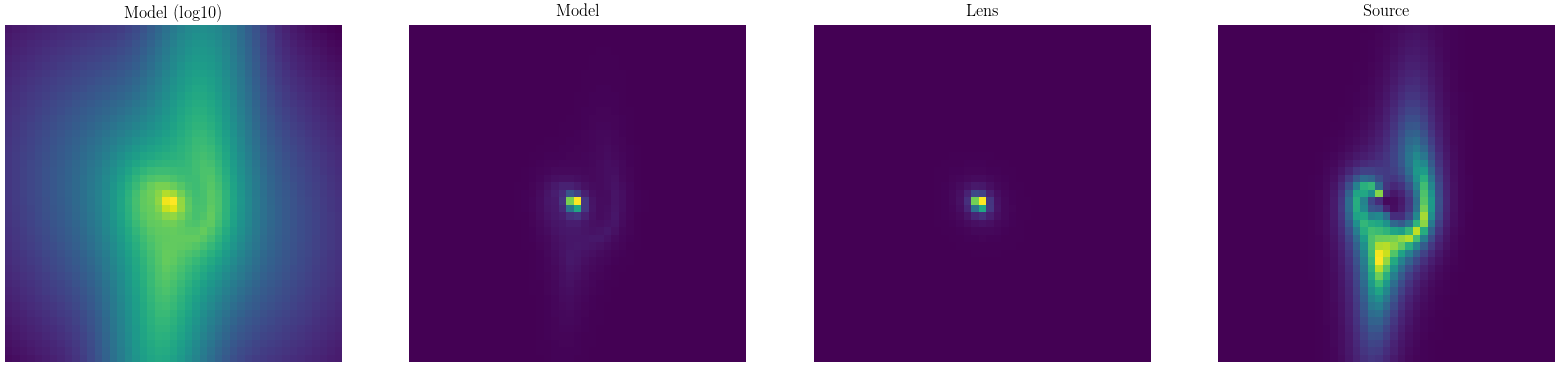

In [4]:
model, lens_sb, source_sb = sample_lens.get_array(num_pix * oversample, side, band, return_pieces=True)

f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(np.log10(model))
ax[0].set_title('Model (log10)')
ax[1].imshow(model)
ax[1].set_title('Model')
ax[2].imshow(lens_sb)
ax[2].set_title('Lens')
ax[3].imshow(source_sb)
ax[3].set_title('Source')
for a in ax: a.axis('off')
plt.show()

Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_1_2048_2048_1.pkl


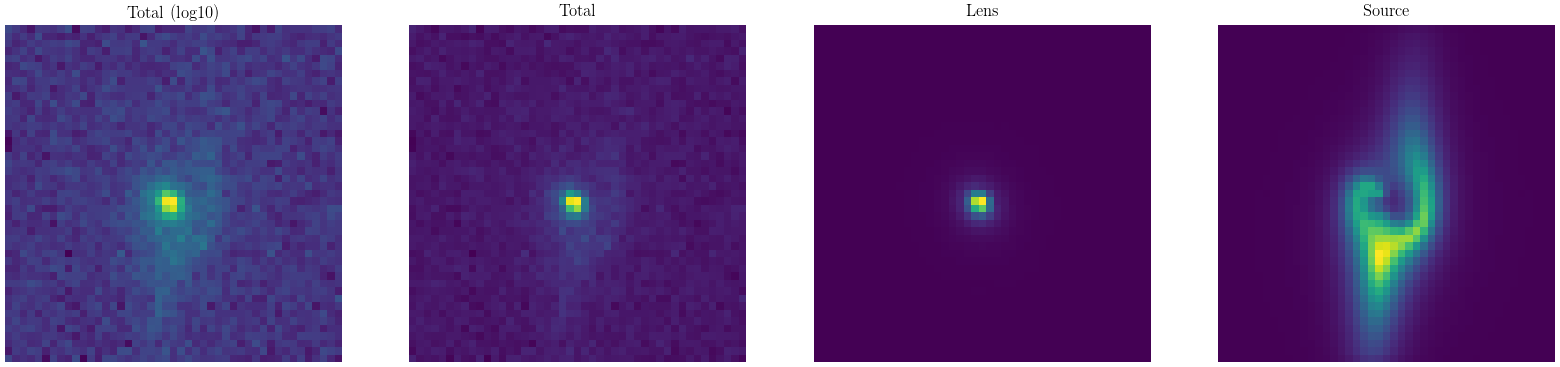

In [5]:
results, lenses, sources, execution_time = gs.get_images(sample_lens, [model], [band], num_pix, num_pix, oversample, oversample,
               lens_surface_brightness=[lens_sb], source_surface_brightness=[source_sb], detector=1, detector_pos=(2048, 2048),
               exposure_time=146, ra=30, dec=-30, seed=42, validate=False, suppress_output=False, check_cache=True)

f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(np.log10(results[0]))
ax[0].set_title('Total (log10)')
ax[1].imshow(results[0])
ax[1].set_title('Total')
ax[2].imshow(lenses[0])
ax[2].set_title('Lens')
ax[3].imshow(sources[0])
ax[3].set_title('Source')
for a in ax: a.axis('off')
plt.show()

In [6]:
# put back into units of counts
total = results[0] * 146
lens = lenses[0] * 146
source = sources[0] * 146

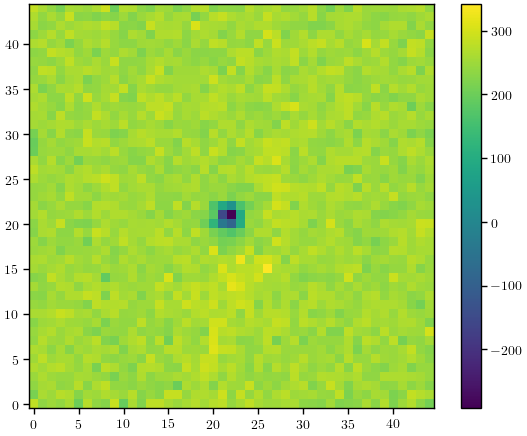

In [7]:
noise = total - (lens + source)

plt.imshow(noise)
plt.colorbar()
plt.show()

# Bryce's first thought that turns out to be bad but seemed reasonable at the time

1. Consider the region where the lensed source is brightest
2. Calculate SNR in that region

In [8]:
mask_mult = 1.

# calculate threshold that will define masked region
stdev = np.std(source)
mean = np.mean(source)
threshold_stdev = mean + (mask_mult * stdev)

# mask source
masked_source = np.ma.masked_where(source < threshold_stdev, source)
source_counts = masked_source.compressed().sum()

# mask lens
masked_lens = np.ma.masked_where(source < threshold_stdev, lens)
lens_counts = masked_lens.compressed().sum()

# mask noise
masked_noise = np.ma.masked_where(source < threshold_stdev, noise)
noise_counts = masked_noise.compressed().sum()

# calculate estimated SNR
snr = source_counts / np.sqrt(source_counts + lens_counts + noise_counts)
print(f'SNR: {snr}')

SNR: 22.46734619140625


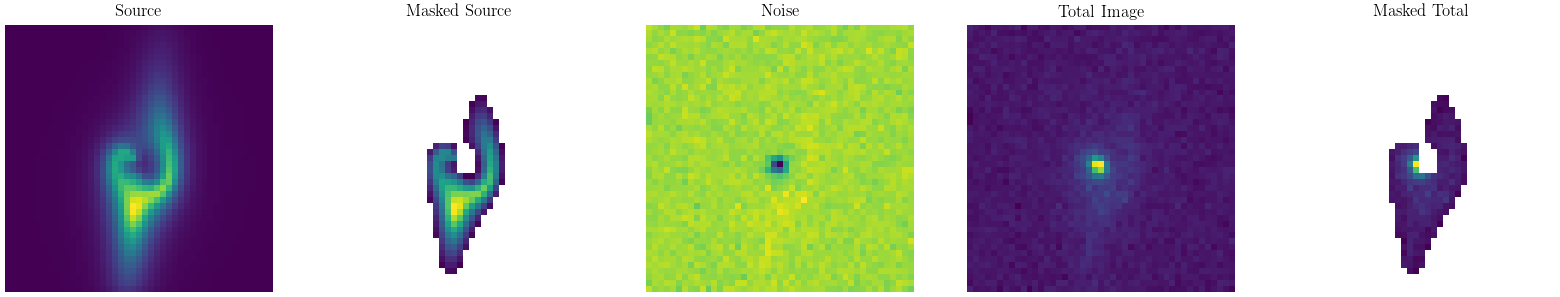

In [9]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))

ax[0].imshow(source)
ax[1].imshow(masked_source)
ax[2].imshow(noise)
ax[3].imshow(total)
ax[4].imshow(np.ma.masked_where(source < threshold_stdev, total))

ax[0].set_title('Source')
ax[1].set_title('Masked Source')
ax[2].set_title('Noise')
ax[3].set_title('Total Image')
ax[4].set_title('Masked Total')

for a in ax: a.axis('off')

plt.show()

In [10]:
# calculate threshold that will define masked region
threshold_quantile = np.quantile(source, 0.98)

# mask source
masked_source = np.ma.masked_where(source < threshold_quantile, source)
source_counts = masked_source.compressed().sum()

# mask lens
masked_lens = np.ma.masked_where(source < threshold_quantile, lens)
lens_counts = masked_lens.compressed().sum()

# mask noise
masked_noise = np.ma.masked_where(source < threshold_quantile, noise)
noise_counts = masked_noise.compressed().sum()

# calculate estimated SNR
snr = source_counts / np.sqrt(source_counts + lens_counts + noise_counts)
print(f'SNR: {snr}')

SNR: 15.641944885253906


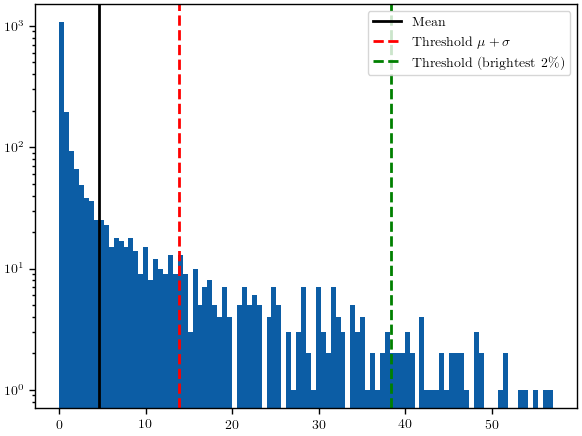

In [11]:
plt.hist(source.flatten(), bins=100)
plt.yscale('log')
plt.axvline(mean, label='Mean', color='k')
plt.axvline(threshold_stdev, color='r', label=r'Threshold $\mu + \sigma$', linestyle='--')
plt.axvline(threshold_quantile, color='g', label=r'Threshold (brightest 2\%)', linestyle='--')
plt.legend()
plt.show()

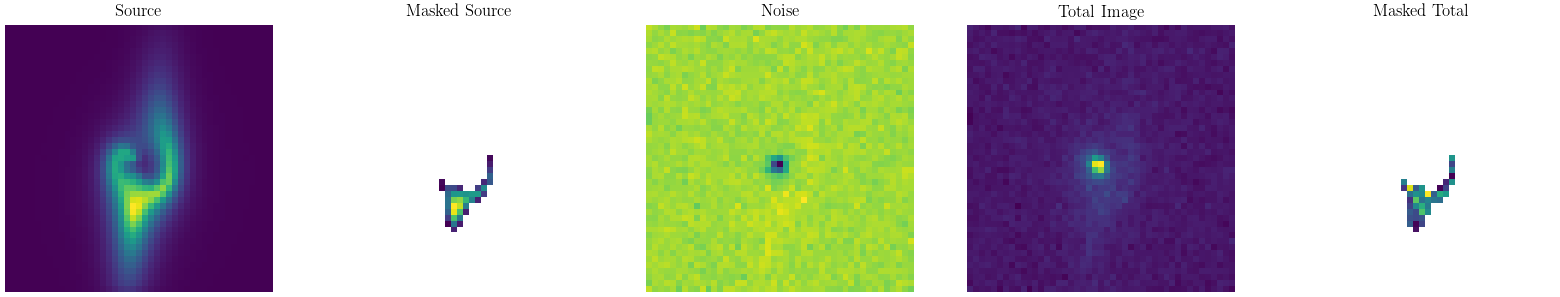

In [12]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))

ax[0].imshow(source)
ax[1].imshow(masked_source)
ax[2].imshow(noise)
ax[3].imshow(total)
ax[4].imshow(np.ma.masked_where(source < threshold_quantile, total))

ax[0].set_title('Source')
ax[1].set_title('Masked Source')
ax[2].set_title('Noise')
ax[3].set_title('Total Image')
ax[4].set_title('Masked Total')

for a in ax: a.axis('off')

plt.show()

In [13]:
lens_subtracted = source + noise

masked_lens_subtracted_image = np.ma.array(mask=masked_source.mask, data=lens_subtracted)
total_lens_subtracted_counts = masked_lens_subtracted_image.compressed().sum()

snr_lens_subtracted = source_counts / np.sqrt(total_lens_subtracted_counts)
print(f'Lens-subtracted SNR: {snr_lens_subtracted}')

Lens-subtracted SNR: 16.299612045288086


The problem: the lensing galaxies are much brighter than the lensed images (our signal), and since light from the lensing galaxy is noise, we need to take it into account.

# A better way

1. Calculate SNR in each pixel
2. Consider the pixels where SNR > 1
3. Adjacent pixels form regions, and if any one region has combined SNR > 20, strong lens is detectable

The pixels where SNR > 1 does a really good job of identifying the lensed images. Then, selecting the region with the best SNR reflects how detection algorithms are looking for any lensed images, where any one is enough (at least for a first pass) to consider the strong lens detectable.

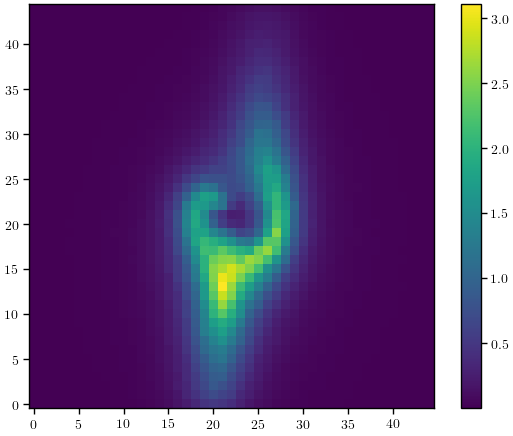

In [14]:
snr_array = source / np.sqrt(total)

plt.imshow(snr_array)
plt.colorbar()
plt.show()

There are regions with SNR > 1


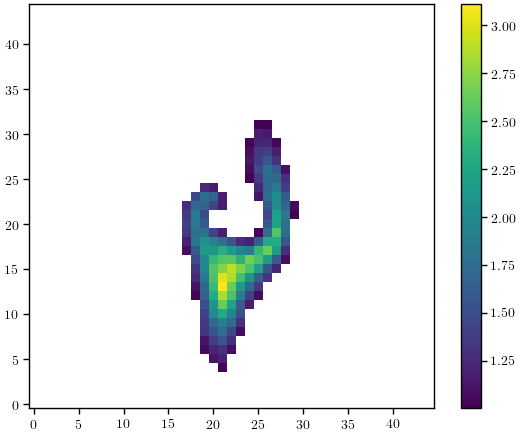

In [15]:
if np.any(snr_array > 1):
    print('There are regions with SNR > 1')
else:
    print('There are no regions with SNR > 1')

regions = np.ma.masked_where(snr_array <= 1, snr_array)

plt.imshow(regions)
plt.colorbar()
plt.show()

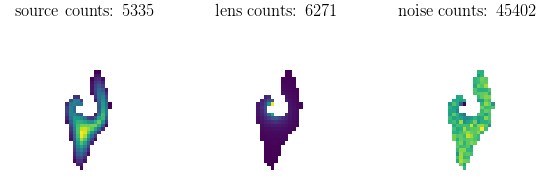

In [16]:
# mask source
masked_source = np.ma.masked_where(snr_array <= 1, source)
source_counts = masked_source.compressed().sum()

# mask lens
masked_lens = np.ma.masked_where(snr_array <= 1, lens)
lens_counts = masked_lens.compressed().sum()

# mask noise
masked_noise = np.ma.masked_where(snr_array <= 1, noise)
noise_counts = masked_noise.compressed().sum()

f, ax = plt.subplots(1, 3)
ax[0].imshow(masked_source)
ax[0].set_title(f'source counts: {source_counts:.0f}')
ax[1].imshow(masked_lens)
ax[1].set_title(f'lens counts: {lens_counts:.0f}')
ax[2].imshow(masked_noise)
ax[2].set_title(f'noise counts: {noise_counts:.0f}')
for a in ax: a.axis('off')
plt.show()

In [17]:
# calculate estimated SNR
snr = source_counts / np.sqrt(source_counts + lens_counts + noise_counts)
print(f'SNR: {snr}')

SNR: 22.34416961669922


In [18]:
# indices = np.transpose(np.nonzero(masked_source))

# numerator, denominator = 0, 0
# for i, j in indices:
#     numerator += masked_source[i, j]
#     denominator += masked_source[i, j] + masked_lens[i, j] + masked_noise[i, j]

# snr = numerator / np.sqrt(denominator)
# print(f'SNR: {snr}')

In [19]:
regions = []
already_checked = set()

for i, j in np.transpose(np.nonzero(masked_source)):
    region = set()

    if (i, j) in already_checked:
        continue
    
    # check left neighbor
    if j != 0 and not masked_source.mask[i, j - 1]:
        region.add((i, j - 1))
    else:
        already_checked.add((i, j - 1))
    # check right neighbor
    if j != masked_source.shape[0]:
        region.add((i, j + 1))
    else:
        already_checked.add((i, j + 1))
    # check bottom neighbor
    if i != 0 and not masked_source.mask[i - 1, j]:
        region.add((i - 1, j))
    else:
        already_checked.add((i - 1, j))
    # check top neighbor
    if i != masked_source.shape[1]:
        region.add((i + 1, j))
    else:
        already_checked.add((i + 1, j))

    # TODO should move on to one of the neighbors instead of the next nonzero element, so that I can stay within one region and define it before moving on to the next region. something needs to prevent me from defining a region prematurely

    # if all neighbors have already been checked, append region and go on to defining next region
    regions.append(region)

In [20]:
print(len(regions))

173
